In [50]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Embedding, Dense, SimpleRNN, LSTM, Bidirectional, Flatten, Dropout
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2, l1_l2

In [2]:
# 데이터 로드
# 세가지 모델 구축, 학습
# 성능 비교 및 시각화
# 예측결과 분석

In [34]:
### 1. 데이터 로드

ids = movie_reviews.fileids()
reviews = [movie_reviews.raw(id) for id in ids]
categoris = [movie_reviews.categories(id)[0] for id in ids]

# 토큰화 및 정수 인코딩
max_word = 10000
tokenizer = Tokenizer(num_words=max_word, oov_token='UNK')
tokenizer.fit_on_texts(reviews) 

# 텍스트를 시퀀스로 변환
x = tokenizer.texts_to_sequences(reviews)
len(x[0]) # --> 문장마다 길이가 다름

# 시퀀스를 패딩
maxlen=500
x = pad_sequences(x, maxlen=maxlen, truncating='pre')

# 레이블 변환
label_dict = {'pos':1, 'neg':0}
y = np.array([label_dict[c] for c in categoris])

# 학습 테스트 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, random_state=42, test_size=0.2)


In [55]:
### 2. 3가지 모델 구축, 학습

# 시드 고정 (재현성)
np.random.seed(42)
tf.random.set_seed (42)

# 모델 성능
results = {}

# ------- model 1 baseline (Flatten + Dense)
model1 = Sequential([
    Embedding(max_word, 32, input_length = maxlen),
    Flatten(),
    Dropout(0.5), 
    Dense(1, activation='sigmoid')
])
model1.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['acc'])
history1 = model1.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
score1 = model1.evaluate(x_test, y_test)
results['baseline'] = score1[1]
print ( f' model 정확도 : {score1[1]:.4f}')


# ------- model 2 (SimpleRNN)
model2 = Sequential([
    Embedding(max_word, 32, input_length = maxlen),
    SimpleRNN(32),
    Dense(32,activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5), 
    Dense(1, activation='sigmoid')
])
model2.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['acc'])
history2 = model2.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
score1 = model2.evaluate(x_test, y_test)
results['Simple_RNN'] = score1[1]
print ( f' model2 정확도 : {score1[1]:.4f}')



# ------- model 3 (Bidirectional)
model3 = Sequential([
    Embedding(max_word, 64, input_length = maxlen),
    Bidirectional(LSTM(64)),
    Dense(64,activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5), 
    Dense(1, activation='sigmoid')
])
model3.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['acc'])
history3 = model3.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
score1 = model3.evaluate(x_test, y_test)
results['Bidirectional_LSTM'] = score1[1]
print ( f' model3 정확도 : {score1[1]:.4f}')





Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.5234 - loss: 0.6935 - val_acc: 0.5531 - val_loss: 0.6906
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9172 - loss: 0.6228 - val_acc: 0.5437 - val_loss: 0.6877
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9641 - loss: 0.5363 - val_acc: 0.5750 - val_loss: 0.6815
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9859 - loss: 0.4204 - val_acc: 0.6313 - val_loss: 0.6728
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9961 - loss: 0.2960 - val_acc: 0.6344 - val_loss: 0.6627
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.9992 - loss: 0.1971 - val_acc: 0.6375 - val_loss: 0.6541
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.9984 - loss: 0.1320 - val_acc: 0.6469 - val_loss: 0.6473
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 1.0000 - loss: 0.0887 - val_acc: 0.6594 - val_loss: 0.6426
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 1.0000

 Bidirectional_LSTM : 0.6300
 baseline : 0.5975
 Simple_RNN : 0.4950


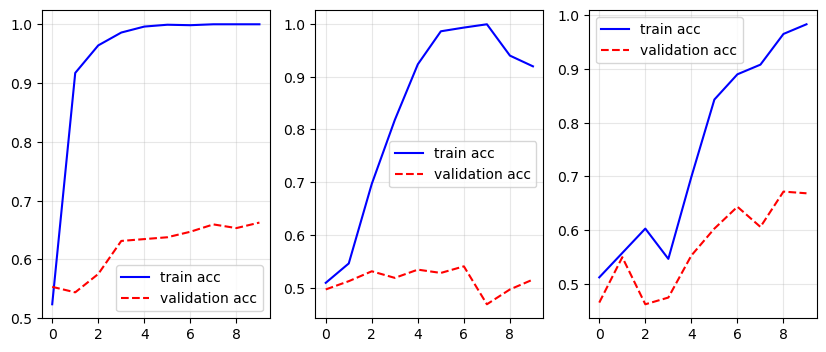

In [57]:
# 3. 성능 비교 및 시각화  (DROPOUT 적용, model2,3에activation='relu', kernel_regularizer=l2(0.01) 추가
for modelname, acc in sorted(results.items(), key=lambda x : x[1], reverse =True):
    print ( f' {modelname} : {acc:.4f}')

fig, ax = plt.subplots(1,3, figsize=(10,4))
# baseline
ax[0].plot(history1.history['acc'], 'b-', label='train acc')
ax[0].plot(history1.history['val_acc'], 'r--', label='validation acc')
ax[0].legend()
ax[0].grid(True,alpha=0.3)

# sampleRNN 
ax[1].plot(history2.history['acc'], 'b-', label='train acc')
ax[1].plot(history2.history['val_acc'], 'r--', label='validation acc')
ax[1].legend()
ax[1].grid(True,alpha=0.3)

# Birdirectional_LSTM
ax[2].plot(history3.history['acc'], 'b-', label='train acc')
ax[2].plot(history3.history['val_acc'], 'r--', label='validation acc')
ax[2].legend()
ax[2].grid(True,alpha=0.3)

================

#### dropout 전

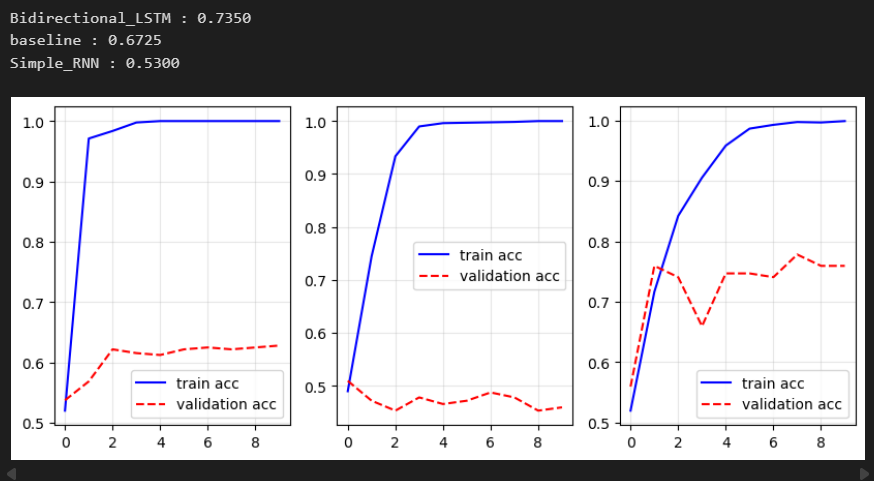


#### dropout 후

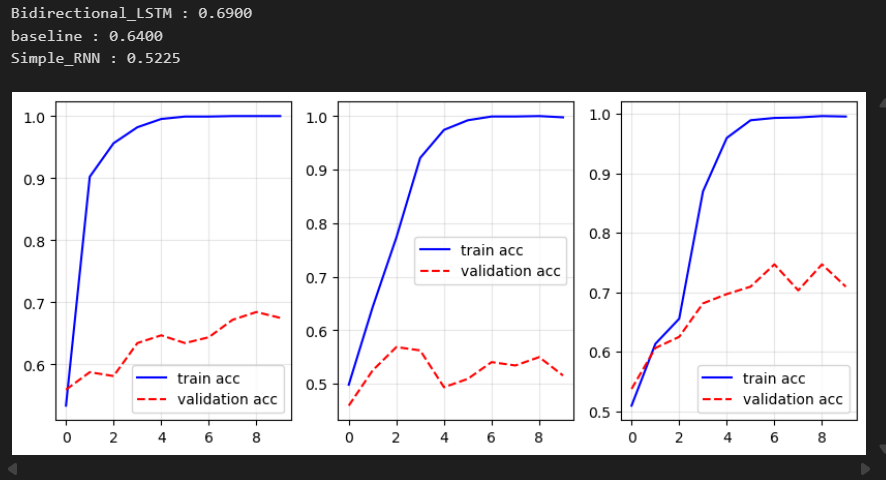

#### dropout 후 모델2,3 에 relu에서 kernel_regularizer 적용

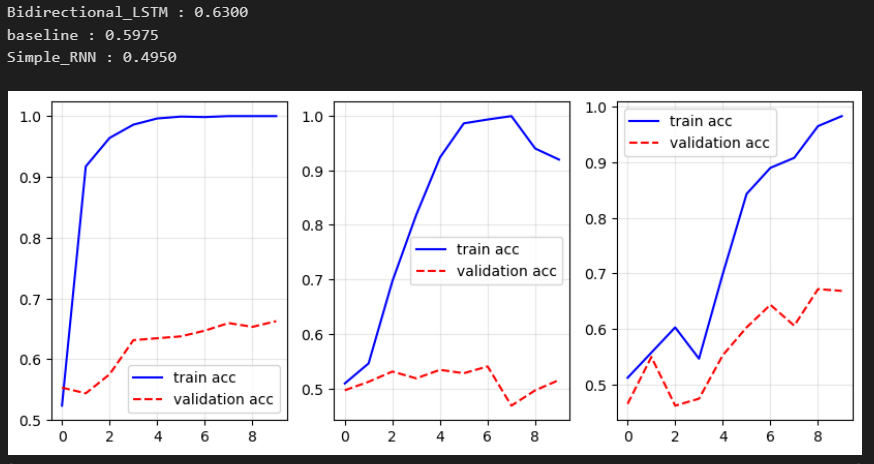
